## 0 - import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from utils import dataframe_info

In [3]:
df = pd.read_csv('./ML/ML_data.csv', low_memory = False)

In [4]:
dataframe_info(df)

,Column,Non-Null Count,NaN Count,NaN Percentage,Dtype,Example Value
0,DeployedFromStation_Name,2363411,0,0.0,object,Battersea
1,DeployedFromLocation,2363411,0,0.0,object,Home Station
2,PumpOrder,2363411,0,0.0,int64,1
3,PlusCode_Description,2363411,0,0.0,object,Initial Mobilisation
4,PropertyCategory,2363411,0,0.0,object,Road Vehicle
5,AddressQualifier,2363411,0,0.0,object,In street close to gazetteer location
6,Easting_rounded,2363411,0,0.0,int64,528650
7,Northing_rounded,2363411,0,0.0,int64,176850
8,NumStationsWithPumpsAttending,2363411,0,0.0,float64,2.0
9,NumPumpsAttending,2363411,0,0.0,float64,2.0


## 1 - filtre rajoutés

In [6]:
#df= df[df['ResponseDuration'] >= 1]

In [5]:
df = df.drop(columns = ["DeployedFromStation_Name"])

## 2 - encodage

In [12]:
df_encoded = df

In [13]:
# Encodage binaire : DeployedFromLocation
encoder = LabelEncoder()
df_encoded['DeployedFromLocation'] = encoder.fit_transform(df_encoded['DeployedFromLocation'])

# Encodage getdummies : "PlusCode_Description", "PropertyCategory","AddressQualifier","IncidentType"
cols_to_encode = cols_to_encode = df_encoded.select_dtypes(include=['object']).columns 
df_encoded = pd.get_dummies(df_encoded, columns=cols_to_encode)

## 3 - train_test_split

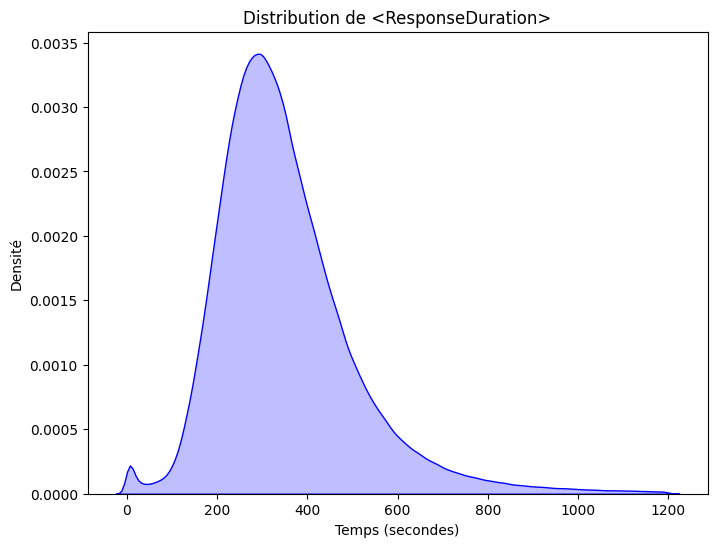

In [14]:
plt.figure(figsize=(8, 6))
sns.kdeplot(df_encoded['ResponseDuration'], fill = True, color='blue')

plt.title('Distribution de <ResponseDuration>')
plt.xlabel('Temps (secondes)')
plt.ylabel('Densité');

In [15]:
bins = [df_encoded['ResponseDuration'].min(), 251, 325, 421, df_encoded['ResponseDuration'].max()]
labels = [0,1,2,3]

df_encoded['ResponseCat'] = pd.cut(df_encoded.ResponseDuration, bins=bins, labels= labels, include_lowest=True)

In [16]:
target = df_encoded['ResponseCat']
df_encoded = df_encoded.drop(columns = ['ResponseDuration'])

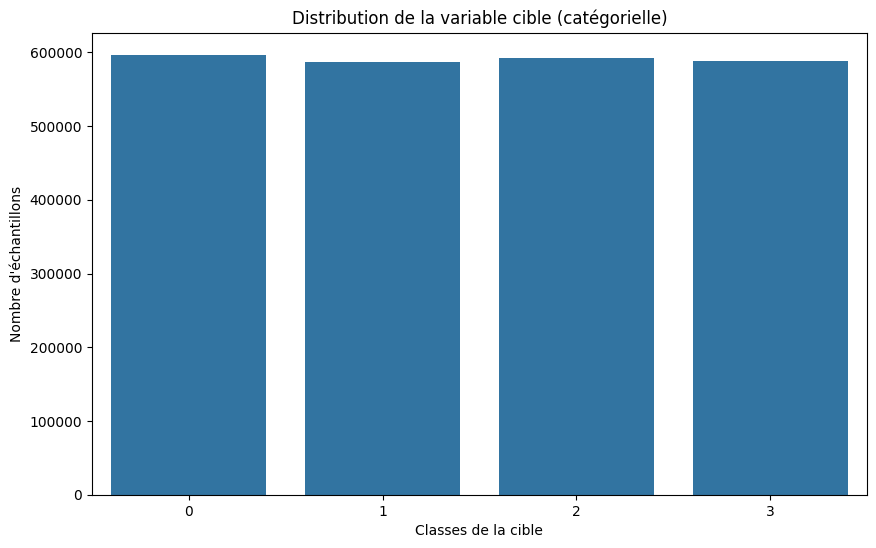

In [17]:
# Affichage de la distribution de la target catégorisée
plt.figure(figsize=(10, 6))
sns.countplot(x=target)
plt.title('Distribution de la variable cible (catégorielle)')
plt.xlabel('Classes de la cible')
plt.ylabel('Nombre d\'échantillons')
plt.show()

In [18]:
X = df_encoded.drop(labels = ["ResponseCat"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,target, test_size=0.2, random_state=42)

### Undersampling

In [20]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = {0: 50000, 1: 50000, 2: 50000, 3: 50000}

rus = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

print('Resampled dataset shape %s' % y_train_resampled.shape)

Resampled dataset shape 200000


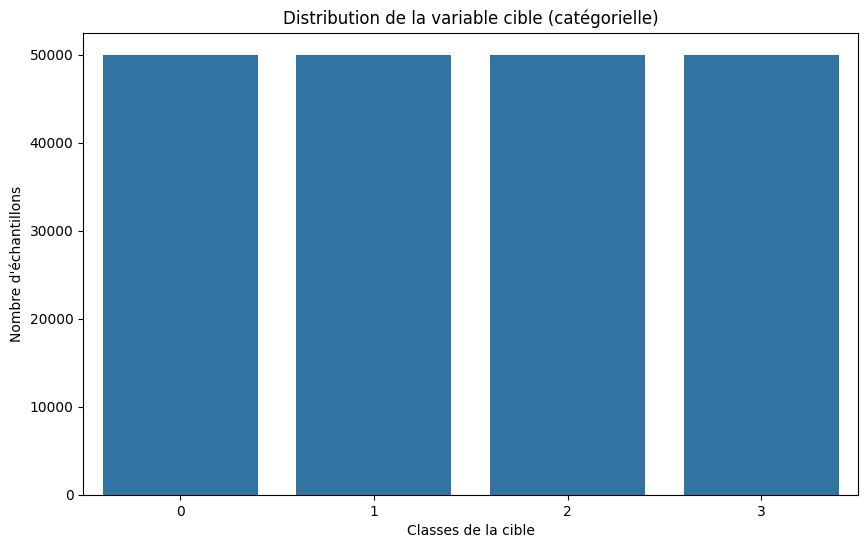

In [21]:
# Affichage de la distribution de la target catégorisée
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train_resampled)
plt.title('Distribution de la variable cible (catégorielle)')
plt.xlabel('Classes de la cible')
plt.ylabel('Nombre d\'échantillons')
plt.show()

## 4 - Normalisation (Standard & Minmax)

In [22]:
X_train = X_train_resampled
y_train = y_train_resampled

In [23]:
# Standard OU minmax
# "Northing_rounded","Easting_rounded", "PumpOrder", "NumStationsWithPumpsAttending", "NumPumpsAttending", "NumCalls", "year"
columns_for_scaling = ["Northing_rounded",
                       "Easting_rounded",
                       "PumpOrder",
                       "NumStationsWithPumpsAttending",
                       "NumPumpsAttending",
                       "NumCalls",
                       "year",
                       "rain", # rajoutée
                       "temperature_2m",  # rajoutée
                       "relative_humidity_2m", # rajoutée
                       "weather_code", # rajoutée
                       "wind_speed_10m", # rajoutée
                       "wind_gusts_10m"] # rajoutée
scaler = StandardScaler()
#scaler = MinMaxScaler()

X_train[columns_for_scaling]= scaler.fit_transform(X_train[columns_for_scaling])
X_test[columns_for_scaling] = scaler.transform(X_test[columns_for_scaling])

In [24]:
dataframe_info(pd.DataFrame(X_train))

,Column,Non-Null Count,NaN Count,NaN Percentage,Dtype,Example Value
0,DeployedFromLocation,200000,0,0.0,int64,0
1,PumpOrder,200000,0,0.0,float64,-0.595599
2,Easting_rounded,200000,0,0.0,float64,-1.887522
3,Northing_rounded,200000,0,0.0,float64,1.175974
4,NumStationsWithPumpsAttending,200000,0,0.0,float64,0.349341
...,...,...,...,...,...,...
67,IncidentType_Spills and Leaks (not RTC),200000,0,0.0,bool,False
68,IncidentType_Stand By,200000,0,0.0,bool,False
69,IncidentType_Suicide/attempts,200000,0,0.0,bool,False
70,IncidentType_Use of Special Operations Room,200000,0,0.0,bool,False


## 5 - Réduction de dimension

In [25]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

## 6 - Deep Learning

In [26]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import BatchNormalization


2024-07-21 23:37:41.052788: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### Modèle 1

In [28]:
num_features = X_train.shape[1]
num_classes = 4

inputs = Input(shape = (num_features,), name = "Input")

dense1 = Dense(units = 32, activation = "tanh", name = 'dense_1')
dense2 = Dense(units = 16, activation = "tanh", name = 'dense_2')
dense3 = Dense(units = 8, activation = "tanh", name = 'dense_3')
dense4 = Dense(units = num_classes, activation = "softmax", name = 'dense_4')

x = dense1(inputs)
x = dense2(x)
x = dense3(x)
outputs = dense4(x)

model1 = Model(inputs = inputs, outputs = outputs)


In [29]:
# Compilation du modèle
model1.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [30]:
# Early stopping pour éviter l'overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [32]:
# Entraînement du modèle
training_history = model1.fit(X_train, y_train,
                             validation_data = (X_test, y_test),
                             epochs = 100, 
                             batch_size = 32,
                             validation_split = 0.2,
                             #class_weight = class_weights_dict,
                             callbacks=[early_stopping])

Epoch 1/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.3647 - loss: 1.2904 - val_accuracy: 0.3966 - val_loss: 1.2491
Epoch 2/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.3995 - loss: 1.2442 - val_accuracy: 0.4011 - val_loss: 1.2424
Epoch 3/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4014 - loss: 1.2361 - val_accuracy: 0.3944 - val_loss: 1.2394
Epoch 4/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4023 - loss: 1.2326 - val_accuracy: 0.4057 - val_loss: 1.2318
Epoch 5/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4051 - loss: 1.2311 - val_accuracy: 0.4069 - val_loss: 1.2306
Epoch 6/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4064 - loss: 1.2288 - val_accuracy: 0.4075 - val_loss: 1.2280
Epoch 7/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4070 - loss: 1.2268 - val_accuracy: 0.4063 - val_loss: 1.2294
Epoch 8/100
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.4083 -

In [33]:
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,110 (35.59 KB)

 Trainable params: 3,036 (11.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,074 (23.73 KB)

In [38]:
# Évaluation du modèle
loss, accuracy = model1.evaluate(X_test, y_test)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

14772/14772 ━━━━━━━━━━━━━━━━━━━━ 10s 649us/step - accuracy: 0.4108 - loss: 1.2238
Validation Loss: 1.2244564294815063
Validation Accuracy: 0.4104272723197937


In [39]:
test_pred = model1.predict(X_test)
test_pred_class = test_pred.argmax(axis=1)
y_test_class = y_test
cnf_matrix = confusion_matrix(y_test_class, test_pred_class)

print(cnf_matrix)
print(classification_report(test_pred_class,y_test_class))

14772/14772 ━━━━━━━━━━━━━━━━━━━━ 9s 640us/step
[[79005 16488 12970 11238]
 [55972 20759 22347 18035]
 [37185 16375 29169 35854]
 [22102  8701 21414 65069]]
              precision    recall  f1-score   support

           0       0.66      0.41      0.50    194264
           1       0.18      0.33      0.23     62323
           2       0.25      0.34      0.29     85900
           3       0.55      0.50      0.53    130196

    accuracy                           0.41    472683
   macro avg       0.41      0.39      0.39    472683
weighted avg       0.49      0.41      0.43    472683



### Modèle 2

In [51]:
y_train_one_hot = to_categorical(y_train, num_classes=4)
y_test_one_hot = to_categorical(y_test, num_classes=4)

In [48]:
# Modèle 2 : Réseau de Neurones Dense (Fully Connected Network)

model2 = Sequential()
model2.add(Input(shape = (num_features,)))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(units = num_classes, activation = "softmax"))

# Compiler le modèle
model2.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [52]:
# Early stopping pour éviter l'overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement du modèle
training_history = model2.fit(X_train, y_train_one_hot,
                             validation_data = (X_test, y_test_one_hot),
                             epochs = 100, 
                             batch_size = 32,
                             validation_split = 0.2,
                             callbacks=[early_stopping])

Epoch 1/100


ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [44]:
# Évaluation du modèle
loss, accuracy = model2.evaluate(X_test, y_test)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 4)

In [ ]:
test_pred = model2.predict(X_test)
test_pred_class = test_pred.argmax(axis=1)
y_test_class = y_test
cnf_matrix = confusion_matrix(y_test_class, test_pred_class)

print(cnf_matrix)
print(classification_report(test_pred_class,y_test_class))